AGN selections

In [4]:
import pandas as pd
import numpy as np
# import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
from palettable.tableau import GreenOrange_12

cmap = GreenOrange_12.hex_colors

In [6]:
import hightolowz

In [7]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97']
zees = [2.07,3.10,3.95,5.03,5.92,6.97]

redshiftz = [x.replace('p','.') for x in redshifts[:5]]

In [10]:
L = 480.279

c = 2.97e8 # m s^-1

In [11]:
directory = '/lustre/scratch/astro/cl478/protoclusters_data/'

In [12]:
selection = 'sfr'

gals = [None] * len(redshifts)

for i, redshift in enumerate(redshifts):

    gals[i] = pd.read_csv(directory+'henriques2015a_z%s_%s_r200.csv' % (redshift, selection), skiprows=122, skipfooter=1, engine='python')

#     gals[i] = pd.concat([gals[i], pd.read_csv(directory+'dgal_%s_%s_r2.5_gals.csv' % (selection, redshift))], axis=1)
#     gals[i] = pd.concat([gals[i], pd.read_csv(directory+'dgal_%s_%s_r5_gals.csv' % (selection, redshift))], axis=1)
#     gals[i] = pd.concat([gals[i], pd.read_csv(directory+'dgal_%s_%s_r7.5_gals.csv' % (selection, redshift))], axis=1)
#     gals[i] = pd.concat([gals[i], pd.read_csv(directory+'dgal_%s_%s_r10_gals.csv' % (selection, redshift))], axis=1)
#     gals[i] = pd.concat([gals[i], pd.read_csv(directory+'dgal_%s_%s_r15_gals.csv' % (selection, redshift))], axis=1)
    

In [7]:
# i = 0

# Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989e30 / (365.25*24*60*60)

# Lbol = epsilon * Mdot * c**2  # J s^-1
# Lbol *= 1e7  # erg s^-1

# quasar_mask = Lbol > 1e44
# np.sum(Lbol > 1e44)

In [8]:
epsilon = 0.1

def luminosity_to_accretion(lum, epsilon):    
    acc = lum / epsilon / c**2
    acc /= 1.989e30
    acc *= (365.25*24*60*60)
    acc /= 1e7
    return acc

quasar_lim = luminosity_to_accretion(1e44, epsilon)
cons_quasar_lim = luminosity_to_accretion(1e45, epsilon)

print quasar_lim, cons_quasar_lim

0.0179868985573 0.179868985573


In [9]:
radio_lim = 0.001
cons_radio_lim = 0.005

#### find quasar distance from protocluster centre

In [31]:
def norm_coods(coods):
    
    coods_temp = coods.copy()

    # normalise coordinate values
    if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2.:
        coods['zn_x'] = coods['zn_x'] - L
        coods.loc[coods['zn_x'] < -L/2., 'zn_x'] = coods_temp[coods_temp['zn_x'] < L/2.]['zn_x']

    if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2.:
        coods['zn_y'] = coods['zn_y'] - L
        coods.loc[coods['zn_y'] < -L/2., 'zn_y'] = coods_temp[coods_temp['zn_y'] < L/2.]['zn_y']

    if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2.:
        coods['zn_z'] = coods['zn_z'] - L
        coods.loc[coods['zn_z'] < -L/2., 'zn_z'] = coods_temp[coods_temp['zn_z'] < L/2.]['zn_z']

    return coods

In [76]:
L = 480.279

for i, redshift in enumerate(redshiftz):
    
    print i, redshift 

    quasars = gals[i][gals[i]['zn_radioAccretionRate'] >= radio_lim].reset_index(drop=True)

    # filter by quasars in protoclusters
    quasars = quasars[quasars['z0_central_mcrit200'] >= 1e4].reset_index(drop=True)
    
    distances = [None] * len(quasars)
    
    print len(quasars)

    for idx, q in quasars.iterrows():

        # subset coordinates of descendant halo
        coods = gals[i][gals[i]['z0_centralId'] == q['z0_centralId']].copy()

        coods = norm_coods(coods)  # normalise coordinates
        center = np.median(coods[['zn_x','zn_y','zn_z']],axis=0) # find descendant halo center
        
        quasar_location = coods[coods['zn_galaxyId'] == q['zn_galaxyId']][['zn_x','zn_y','zn_z']]

        # distance between quasar and descendant halo progenitor centre
        distances[idx] = float(np.sqrt(np.sum((quasar_location - center)**2, axis=1)))
    
    print np.mean(distances), np.median(distances), np.std(distances)

0 2.07
3569
2.74306143041 2.35048820119 2.03768417542
1 3.10
822
2.94660710488 2.4417474467 2.26759197232
2 3.95
128
3.34080173388 2.72300306907 2.30230312025
3 5.03
5
3.2112904701 2.31797701395 3.208568997


0 2.07
8925
3.21442733501 2.92480915626 2.06333160106
1 3.10
2607
3.34548464094 2.92734872254 2.28813400814
2 3.95
551
3.16184318719 2.6850769842 2.25125886361
3 5.03
46
2.98101492963 2.06611731764 2.51153473201

#### Find average galaxy distance from protocluster centre

In [46]:
gals_sm = [None] * len(redshifts)
gals_sfr = [None] * len(redshifts)

for i, redshift in enumerate(redshifts):

    gals_sm[i] = pd.read_csv(directory+'henriques2015a_z%s_%s_r200.csv' % (redshift, 'stellarMass'),
                          skiprows=122, skipfooter=1, engine='python')
    
    gals_sfr[i] = pd.read_csv(directory+'henriques2015a_z%s_%s_r200.csv' % (redshift, 'sfr'),
                          skiprows=122, skipfooter=1, engine='python')
    

In [98]:
gals = gals_sfr

L = 480.279

distances = [None] * len(redshiftz)
centres = [None] * len(redshiftz)

for i, redshift in enumerate(redshiftz):
    
    print i, redshift
    
    clusters = pd.unique(gals[i][gals[i]['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    
    distances[i] = [None] * len(clusters)
    centres[i] = [None] * len(clusters)

    for idx, c in enumerate(clusters):

        # subset coordinates of descendant halo
        coods = gals[i][gals[i]['z0_centralId'] == c].copy()

        coods = norm_coods(coods)  # normalise coordinates
        center = np.median(coods[['zn_x','zn_y','zn_z']],axis=0) # find descendant halo center
        
        centres[i][idx] = center
        distances[i][idx] = np.mean(np.sqrt(np.sum(pow(coods[['zn_x','zn_y','zn_z']] - center, 2.),axis=1)))

    
# distances_sfr = distances
# centres_sfr = centres

# distances_sm = distances
# centres_sm = centres

0 2.07
1 3.10
2 3.95
3 5.03
4 5.92


(array([ 2132.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     4.]),
 array([   0.        ,   48.05362073,   96.10724147,  144.1608622 ,
         192.21448293,  240.26810366,  288.3217244 ,  336.37534513,
         384.42896586,  432.4825866 ,  480.53620733]),
 <a list of 10 Patch objects>)

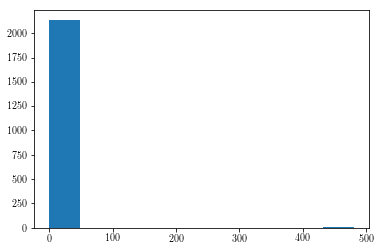

In [105]:
plt.hist(np.sqrt(np.sum(pow(np.array(centres_sfr[0]) - np.array(centres_sm[0]),2),axis=1)))

In [110]:
print centres_sfr[0][858]
print centres_sm[0][858]

[ -6.4425    37.62117   60.228027]
[ 474.093445    37.616228    59.7259385]


In [97]:
centres_sm

[[array([  7.2363777,  15.29746  ,   1.3922015]),
  array([  9.5003085,  56.1026115,  25.7068105]),
  array([  1.5009335,   3.2974393,  37.343273 ]),
  array([ 25.053911,  52.729733,  40.52026 ]),
  array([ 27.018799,  63.882603,  43.30111 ]),
  array([ 14.90214  ,   5.6007667,  48.63943  ]),
  array([ 16.731048,  23.117876,   9.378138]),
  array([ 40.917664,  32.17337 ,   8.86292 ]),
  array([ 41.229485,  46.629887,  33.675648]),
  array([ -3.78700000e-01,   1.57067810e+01,   4.74721500e+02]),
  array([ 59.416338  ,  60.7872545 ,   0.07245571]),
  array([ 7.7357397, -3.78315  , -0.18064  ]),
  array([  6.16902565,  35.8568975 ,   8.351017  ]),
  array([ 63.93418 ,  79.08341 ,  37.241486]),
  array([ 44.26059 ,  91.02964 ,   4.083262]),
  array([  55.3315  ,   69.823715,  476.21085 ]),
  array([ 99.92336 ,  67.55119 ,   3.036489]),
  array([ 118.339783 ,   39.9642665,   15.550476 ]),
  array([ 85.967705 ,  47.4230715,  78.459235 ]),
  array([ 87.15555 ,  22.200758,  70.068504]),
  arra

In [89]:
np.array([np.mean(d) for d in distances_sfr]) - np.array([np.mean(d) for d in distances])

array([ 0.17565368,  0.22326523,  0.32186496,  0.57394775,  1.16955296])

In [91]:
[np.mean(d) for d in distances]

[3.1805097815790466,
 3.638861706029783,
 3.7562005969792125,
 3.6596361549541809,
 3.127022526595276]

In [92]:
[np.mean(d) for d in distances_sfr]

[3.3561634645848688,
 3.8621269365137061,
 4.0780655571072018,
 4.2335839075303445,
 4.2965754889552787]

Eddington accretion rate distribution

[  2.22995519e-05   8.91982076e-05   6.02087901e-04   2.40835161e-03
   7.38115168e-03   1.75720469e-02   3.13308704e-02   6.43342072e-02
   2.03126618e-01   2.11439891e+00]


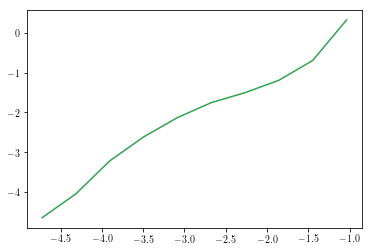

In [509]:
i = 0

Mbh = gals[i]['zn_blackHoleMass']

Ledd = 1.4e46 * Mbh * 10**2 # erg s^-1
Ledd /= 1e7 # j s^-1

Medd = Ledd / (0.1 * c**2) # kg s^-1
Medd /= 1.989e30           # Msol s^-1
Medd *= (365.25*24*60*60)  # Msol yr^-1

mdot = gals[i]['zn_quasarAccretionRate'] / Medd

phi, bins = np.histogram(np.log10(mdot[mdot > 0.]), normed=True)
# phi /= (bins[1] - bins[0])

print phi

plt.plot(bins[1:] - (bins[1] - bins[0]), np.log10(phi), label=redshiftz[i], c=cmap[i])

Black Hole mass function

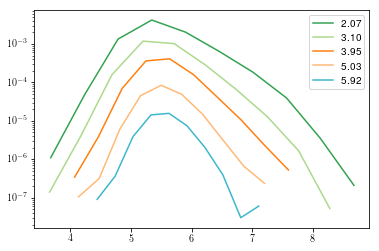

In [503]:
for i in range(5):

    Mbh = np.log10(gals[i]['zn_blackHoleMass'][gals[i]['zn_blackHoleMass'] > 0.] * 1e10)

    phi, bins = np.histogram(Mbh) #, bins=massBinLimits)
    GSMF = phi / L**3 / (bins[1] - bins[0])
    plt.semilogy(bins[1:] - (bins[1] - bins[0]), GSMF, label=redshiftz[i], c=cmap[i])
    
plt.legend()

Radio and quasar mode accretion rate distributions with redshift

(1e-08, 0.01)

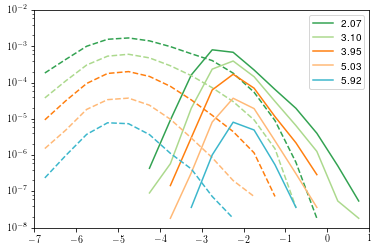

In [215]:

massBinLimits = np.linspace(-7, 1, 17)
massBins = np.linspace(-6.75, 0.75, 16)


for i in range(5):
    
    ### Quasar ###
    Lbol = gals[i]['zn_quasarAccretionRate'] #/ (365.25*24*60*60) * c**2 * epsilon * 1e7
    
    phi, bins = np.histogram(np.log10(Lbol[Lbol>0.]), bins=massBinLimits)
    GSMF = phi / L**3 / (massBinLimits[1] - massBinLimits[0])
    plt.semilogy(massBins, GSMF, label=redshiftz[i], c=cmap[i])
    

    ### Radio ###
    Lbol = gals[i]['zn_radioAccretionRate'] #/ (365.25*24*60*60) * c**2 * epsilon * 1e7
    
    phi, bins = np.histogram(np.log10(Lbol[Lbol>0.]), bins=massBinLimits)
    GSMF = phi / L**3 / (massBinLimits[1] - massBinLimits[0])
    plt.semilogy(massBins, GSMF, c=cmap[i], linestyle='dashed')#label=redshiftz[i],
    
    
plt.legend()
plt.xlim(massBinLimits[0],massBinLimits[-1])

plt.vlines(13, 1e-8, 1e-2, linestyle='dashed', color='grey', alpha=0.5)
plt.ylim(1e-8,1e-2)

Hopkins+07 bolometric luminosity function fits for all redshifts

In [510]:
def hopkins_log_phi(logL, z):
    log_phi_star = 10**-4.825
    
    gamma1 = 0.417
    gamma2 = 2.174
    
    eta = np.log10((1+z)/(1+2))
    Lstar = 10**(13.036 + 0.632*eta - 11.76 * eta**2 - 14.25*eta**3)
    
    return log_phi_star / (((10**logL)/Lstar)**gamma1 + ((10**logL)/Lstar)**gamma2)

In [513]:
hopkins_log_phi(bins, 2)

array([  5.67233541e-04,   3.50962947e-04,   2.17148318e-04,
         1.34344593e-04,   8.30703510e-05,   5.11539512e-05,
         3.05537722e-05,   1.49806532e-05,   3.60788667e-06,
         3.97413034e-07,   3.40861845e-08,   2.80763895e-09])

Quasar bolometric luminosity function

0
1
2
3
4


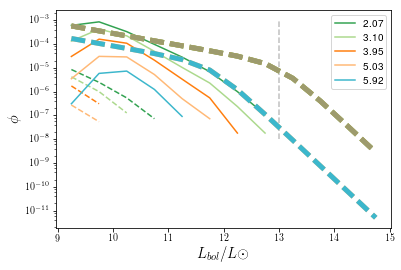

In [514]:
binLimits = np.linspace(9, 15, 13)
bins = np.linspace(9.25, 14.75, 12)

def accr_to_lbol(accr):
    return accr / (365.25*24*60*60) * c**2 * epsilon * 1.989e30 * 1e7 / 3.9e33

for i in range(5):
    
    print i
    
    ### Quasar ###
    Lbol = accr_to_lbol(gals[i]['zn_quasarAccretionRate'])
    
    phi, dummy = np.histogram(np.log10(Lbol[Lbol>0.]), bins=binLimits)
    GSMF = phi / L**3 / (binLimits[1] - binLimits[0])
    plt.semilogy(bins, GSMF, label=redshiftz[i], c=cmap[i])
    
    # protoclusters
    Lbol = accr_to_lbol(gals[i]['zn_quasarAccretionRate'][gals[i]['z0_central_mcrit200'] > 1e4])
    
    phi, dummy = np.histogram(np.log10(Lbol[Lbol>0]), bins=massBinLimits)
    GSMF = phi / L**3 / (binLimits[1] - binLimits[0])
    plt.semilogy(bins, GSMF, linestyle='dashed', c=cmap[i])
    
    
    ## Hopkins+07
    plt.semilogy(bins, hopkins_log_phi(bins, i+2), c=cmap[i], linestyle='dashed', linewidth=5)#, alpha=0.5)
    
    
plt.semilogy(bins, hopkins_log_phi(bins, 2), c=cmap[i], linestyle='dashed', linewidth=5, alpha=0.5)
# plt.semilogy(bins, hopkins_log_phi(bins, 5), c=cmap[i], linestyle='dashed', linewidth=5, alpha=0.5)

plt.legend()

# plt.xlim(binLimits[0],binLimits[-1])
# plt.ylim(1e-8,1e-3)

plt.vlines(13, 1e-8, 1e-3, linestyle='dashed', color='grey', alpha=0.5)

plt.xlabel('$L_{bol} / L{\odot}$', size=15)
plt.ylabel('$\phi$', size=15)

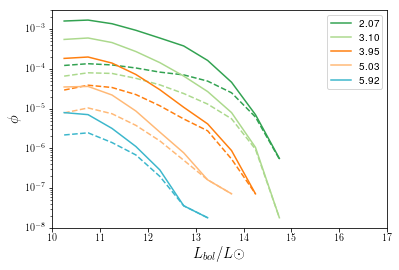

In [386]:
binLimits = np.linspace(10, 17, 15)
bins = np.linspace(10.25, 16.75, 14)

for i in range(5):
    Lbol = gals[i]['zn_radioAccretionRate'] / (365.25*24*60*60) * c**2 * epsilon * 1e7
    
    phi, dummy = np.histogram(np.log10(Lbol[Lbol>0]), bins=binLimits)
    GSMF = phi / L**3 / (binLimits[1] - binLimits[0])
    plt.semilogy(bins, GSMF, label=redshiftz[i], c=cmap[i])
    
    # protoclusters
    Lbol = gals[i]['zn_radioAccretionRate'][gals[i]['z0_central_mcrit200'] > 1e4] \
    / (365.25*24*60*60) * c**2 * epsilon * 1e7
    
    phi, dummy = np.histogram(np.log10(Lbol[Lbol>0]), bins=binLimits)
    GSMF = phi / L**3 / (binLimits[1] - binLimits[0])
    plt.semilogy(bins, GSMF, linestyle='dashed', c=cmap[i])
    
    
plt.legend()
plt.xlim(binLimits[0],binLimits[-1])
plt.xlabel('$L_{bol} / L{\odot}$', size=15)
plt.ylabel('$\phi$', size=15)

0 2.07
1 3.10
2 3.95
3 5.03


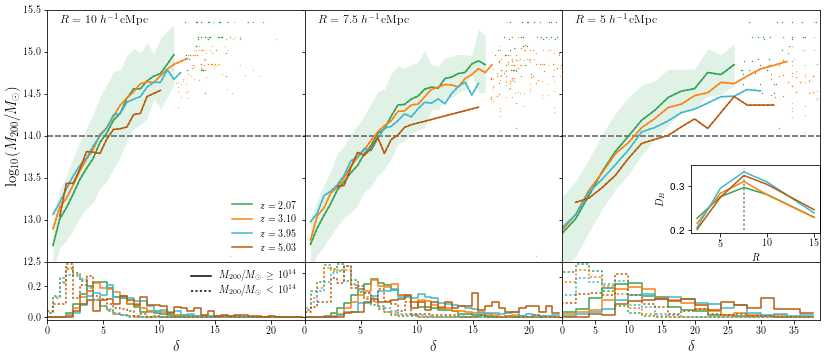

In [83]:
BinLimits = [np.linspace(-1, 11, 25), 
             np.linspace(-1, 23, 41),
             np.linspace(-1, 23, 41), 
             np.linspace(-1, 39, 21)]

Bins = [np.linspace(-0.75, 10.75, 24),
        np.linspace(-0.7, 22.7, 40), 
        np.linspace(-0.7, 22.7, 40),
        np.linspace(0, 38, 20)]

fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])

ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])

ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])

ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(redshiftz))]

radii = [10,7.5,5]

for i, redshift in enumerate(redshiftz):
    
    print i, redshift

    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim

    mask = ~np.isnan(np.log10(gals[i]['z0_central_mcrit200'] * 1e10))
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits[1:4], Bins[1:4]):
        
        # Subplot
        phiB, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R] + 1,
                                     bins=binLimits, normed=True)
        
        
        phiA, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R] + 1,
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)

        # Main Plot
        median = binned_statistic(gals[i][quasar_mask]['dgal_%s'%R][mask] + 1, 
                          np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(gals[i][quasar_mask]['dgal_%s'%R][mask] + 1, 
                                  np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                  bins=binLimits, statistic='count')[0]

        std = binned_statistic(gals[i][quasar_mask]['dgal_%s'%R][mask] + 1, 
                                 np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                 bins=binLimits, statistic='std')[0]

        cmask = (count > 10)
        
        if i==0:
            axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                             alpha=0.15, linewidth=0, color=cmap[i*2])

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %s$'%redshift)
        
        axt.scatter(gals[i][quasar_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['dgal_%s'%R] + 1,
            np.log10(gals[i][quasar_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['z0_central_mcrit200'] * 1e10),
            marker='.', s=8, c=cmap[i], lw=0, label=None)
        
#         axb.set_xlim(binLimits[0], binLimits[-1])
#         axt.set_xlim(binLimits[0], binLimits[-1])

        axb.set_xlim(0, binLimits[-1])
        axt.set_xlim(0, binLimits[-1])

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], linestyle='dotted')

        axt.hlines(14, -10, 60, linestyle='--', color='grey')
        
        axt.set_xticklabels([])

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        phi, mass = np.histogram(gals[i]['dgal_%s'%R], bins=binLimits, normed=True)

        if(i==0):
            axt.text(0.05, 0.95, '$R = %s \; h^{-1} \, \mathrm{cMpc}$'%R, transform=axt.transAxes, size=12)


## Calculate R = 15 & 2.5 Bhattacharya distance, but don't plot
for i, redshift in enumerate(redshiftz):
    
    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim
    
    for R, switch in zip([15,2.5],[True,False]):
    
        phiB, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R] + 1,
                                     bins=binLimits, normed=True)
        phiA, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R] + 1,
                                 bins=binLimits, normed=True)
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
        

for i,z in enumerate(redshiftz):
    ax9.plot([15] + radii + [2.5], Bhatta[i], color=cmap[i*2])
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')

# ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.5,15.5)

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} / M_{\odot} \, \geq \, 10^{14}$',
                   r'$M_{200} / M_{\odot} \, < \, 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False)

for ax in [ax2,ax3,ax6,ax7]:
    ax.set_yticklabels([])

for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta$', size=15, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=8)  

# plt.savefig('../papers/protoclusters/images/quasar_select.png', bbox_inches='tight', dpi=300)

0 2.07
1 3.10
2 3.95
3 5.03
[  1.75910364e-02   2.93333333e-01   1.61064426e-01   2.40896359e-02
   3.80952381e-03   1.12044818e-04   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00] [  1.49767583e-01   3.10851905e-01   3.73604414e-02   1.95490682e-03
   6.51635605e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[ 0.01921687  0.02572289  0.01518072  0.03542169  0.01981928  0.04108434
  0.02240964  0.04518072  0.02319277  0.04722892  0.02198795  0.04620482
  0.03463855  0.01614458  0.02716867  0.01228916  0.02036145  0.00753012
  0.01337349  0.00584337] [ 0.06565832  0.06618063  0.0360174

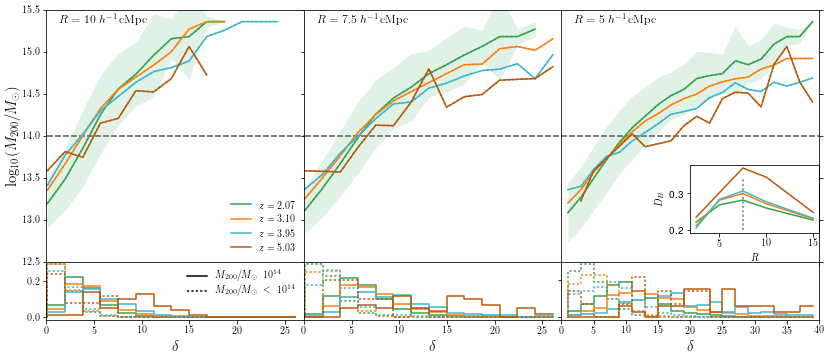

In [82]:
BinLimits = [np.linspace(0, 12, 13), 
             np.linspace(0, 27, 16),
             np.linspace(0, 27, 16), 
             np.linspace(0, 40, 21)]

Bins = [np.linspace(0.5, 11.5, 12),
        np.linspace(0.1, 26.1, 15), 
        np.linspace(0.1, 26.1, 15),
        np.linspace(1, 39, 20)]

fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])

ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])

ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])

ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(redshiftz))]

radii = [10,7.5,5]

for i, redshift in enumerate(redshiftz):
    
    print i, redshift

    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim

    mask = ~np.isnan(np.log10(gals[i]['z0_central_mcrit200'] * 1e10))
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits[1:4], Bins[1:4]):
        
        # Subplot
        phiB, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R] +1,
                                     bins=binLimits, normed=True)
        
        
        phiA, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R] +1,
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)
        
#         axb.set_xlim(binLimits[0], binLimits[-1])
#         axt.set_xlim(binLimits[0], binLimits[-1])

        axb.set_xlim(0, binLimits[-1])
        axt.set_xlim(0, binLimits[-1])

        
        # Main Plot
        median = binned_statistic(gals[i][radio_mask]['dgal_%s'%R][mask] +1, 
                          np.log10(gals[i][radio_mask]['z0_central_mcrit200'] * 1e10)[mask],
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(gals[i][radio_mask]['dgal_%s'%R][mask] +1, 
                                  np.log10(gals[i][radio_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                  bins=binLimits, statistic='count')[0]

        std = binned_statistic(gals[i][radio_mask]['dgal_%s'%R][mask] +1, 
                                 np.log10(gals[i][radio_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                 bins=binLimits, statistic='std')[0]

        cmask = (count > 0)
        
        if np.sum(cmask) == 0:
            print 'not enough radio galaxies...'
        else:
            
            if i ==0:
                axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                                 alpha=0.15, linewidth=0, color=cmap[i*2])

            axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %s$'%redshift)

            axt.scatter(gals[i][radio_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['dgal_%s'%R]+1,
                np.log10(gals[i][radio_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['z0_central_mcrit200'] * 1e10),
                marker='.', s=8, c=cmap[i], lw=0, label=None)

            axt.plot(bins[cmask], median[cmask], color=cmap[i*2], linestyle='dotted')

            axt.hlines(14, -10, 60, linestyle='--', color='grey')

            axt.set_xticklabels([])

            axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
            axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

            phi, mass = np.histogram(gals[i]['dgal_%s'%R], bins=binLimits, normed=True)

        if(i==0):
            axt.text(0.05, 0.95, '$R = %s \; h^{-1} \, \mathrm{cMpc}$'%R, transform=axt.transAxes, size=12)


## Calculate R = 2.5 & 15 Mpc/h Bhattacharya distance, but don't plot
for i, redshift in enumerate(redshiftz):
    
    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim
    
    for R, switch in zip([15,2.5],[True,False]):
        
        phiB, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R]+1,
                                     bins=binLimits, normed=True)
        
        phiA, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R]+1,
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
            

            
for i,z in enumerate(redshiftz):
    ax9.plot([15]+radii+[2.5], Bhatta[i], color=cmap[i*2])
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')

# ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.5,15.5)

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} / M_{\odot} \; \geqslant \; 10^{14}$',
                   r'$M_{200} / M_{\odot} \; < \; 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False)

ax2.set_yticklabels([])
#ax3.set_yticklabels([])

ax6.yaxis.tick_right()
ax3.yaxis.tick_right()

for ax in [ax2,ax3,ax6,ax7]:
    ax.set_yticklabels([])

for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta$', size=15, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=7)  

# plt.savefig('../papers/protoclusters/images/radio_select.png', bbox_inches='tight', dpi=300)

In [101]:
from periodic_kdtree import PeriodicCKDTree

def calc_agn_frac(gals, L, quasar_lim, radio_lim):

    cluster_ids = pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    
    N_quasar = [None] * len(cluster_ids)
    N_radio = [None] * len(cluster_ids)

    dimensions = np.array([L, L, L])

    print "Building periodic KDtree..."
    T = PeriodicCKDTree(dimensions, gals[['zn_x','zn_y','zn_z']])
    
    print "Looping through clusters..."    
    for i, cluster in enumerate(cluster_ids):
        
#         Mdot = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
#         Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
#         N_agn[i] = np.sum(Lbol > 1e44)
        quasar_mask = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] > quasar_lim
        radio_mask = gals[gals['z0_centralId']==cluster]['zn_radioAccretionRate'] > radio_lim
        
        N_quasar[i] = np.sum(quasar_mask)
        N_radio[i] = np.sum(radio_mask)
        
    return N_quasar, N_radio, len(cluster_ids)

In [102]:
n_quasar = [None] * len(redshifts)
n_radio = [None] * len(redshifts)

n_quasar_cons = [None] * len(redshifts)
n_radio_cons = [None] * len(redshifts)

n_clust = [None] * len(redshifts)

for i,z in enumerate(redshifts):
    n_quasar[i], n_radio[i], n_clust[i] = calc_agn_frac(gals[i], L, quasar_lim, radio_lim)
    n_quasar_cons[i], n_radio_cons[i], n_clust[i] = calc_agn_frac(gals[i], L, cons_quasar_lim, cons_radio_lim)

Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...


In [103]:
quasar_in_pcs = [None] * len(gals)
radio_in_pcs = [None] * len(gals)

all_quasar = [None] * len(gals)
all_radio = [None] * len(gals)

quasar_in_pcs_cons = [None] * len(gals)
radio_in_pcs_cons = [None] * len(gals)

all_quasar_cons = [None] * len(gals)
all_radio_cons = [None] * len(gals)

for i in range(len(gals)):
    clust = gals[i]['z0_central_mcrit200'] > 1e4

    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim

    quasar_in_pcs[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar[i] = np.sum(quasar_mask)
    all_radio[i] = np.sum(radio_mask)
    
    quasar_mask = gals[i]['zn_quasarAccretionRate'] > cons_quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > cons_radio_lim

    quasar_in_pcs_cons[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs_cons[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar_cons[i] = np.sum(quasar_mask)
    all_radio_cons[i] = np.sum(radio_mask)
    

In [104]:
n_clust = np.array(n_clust)
n_clust

array([2136, 2136, 2136, 2136, 2087, 1602])

In [105]:
print np.array([np.sum([x > 0 for x in y]) for y in n_quasar])
print np.array([np.sum([x > 0 for x in y]) for y in n_quasar_cons])

[1219  953  562  190   46   11]
[220  76  23   4   1   0]


In [106]:
print np.array([np.sum([x > 0 for x in y]) for y in n_radio])
print np.array([np.sum([x > 0 for x in y]) for y in n_radio_cons])

[2114 1413  458   43    5    0]
[1800  654  117    5    1    0]


In [107]:
print np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar]) / n_clust
print np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar_cons]) / n_clust

[ 0.57069288  0.44616105  0.26310861  0.08895131  0.02204121  0.00686642]
[ 0.10299625  0.03558052  0.01076779  0.00187266  0.00047916  0.        ]


In [112]:
from astropy.cosmology import Planck13, z_at_value
import astropy.units as u

ages = np.array([4, 3, 2.5, 2.1, 1.8, 1.6, 1.4, 1.25, 1.1, 1.0, 0.9])*u.Gyr

ageticks = [z_at_value(Planck13.age, age) for age in ages]

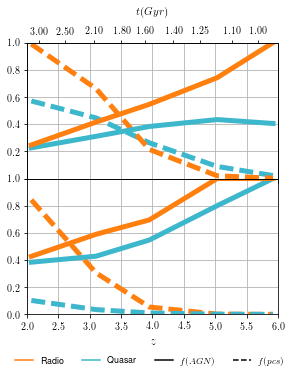

In [118]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4.5,5))

plt.subplots_adjust(hspace=0)

z_lim = 5

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar[:z_lim]]) / n_clust[:z_lim], 
        c=cmap[4], lw=5, linestyle='dashed')

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio[:z_lim]]) / n_clust[:z_lim], 
          c=cmap[2], lw=5, linestyle='dashed')

# cons
ax2.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[2], lw=5, linestyle='dashed')

ax2.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[4], lw=5, linestyle='dashed')


ax1.plot(zees[:z_lim], np.array(quasar_in_pcs[:z_lim])/np.array(all_quasar[:z_lim]), c=cmap[4], lw=5)
ax1.plot(zees[:z_lim], np.array(radio_in_pcs[:z_lim])/np.array(all_radio[:z_lim]), c=cmap[2], lw=5)

#cons
ax2.plot(zees[:z_lim], np.array(quasar_in_pcs_cons[:z_lim])/np.array(all_quasar_cons[:z_lim]), c=cmap[4], lw=5)
ax2.plot(zees[:z_lim], np.array(radio_in_pcs_cons[:z_lim])/np.array(all_radio_cons[:z_lim]), c=cmap[2], lw=5)


ax2.set_xlabel('$z$', size=13)

for ax in [ax1,ax2]:
    ax.set_ylim(0, 1)
    ax.grid()
    #ax.set_ylabel('$f$', rotation=0, size=20)
    
axt = ax1.twiny()
axt.set_xticks(ageticks)
axt.set_xticklabels(["$%.2f$"%age for age in ages.value]);

axt.set_xlabel('$t (Gyr)$', size=11, labelpad=12)

ax1.set_xticklabels([])
ax1.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])

ax1.set_xlim(2, 6)
ax2.set_xlim(2, 6)
axt.set_xlim(2, 6)

line1 = plt.Line2D((0,1),(0,0), color=cmap[2], linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color=cmap[4], linestyle='solid')

line3 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')

ax2.legend(handles=[line1, line2, line3, line4], 
           labels=['Radio','Quasar',r'$f(AGN)$',r'$f(pcs)$'], 
           loc=(-0.06, -0.4), prop={'size':9}, frameon=False, ncol=4)


# plt.savefig('../papers/protoclusters/images/agn_stats.png', bbox_inches='tight', dpi=300)